<table width="50%"><tr>
<td> <img src="../../img/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="../../img/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

# **Robust streamline averaging**

Experiment comparing different approaches to remove spurious streamlines that are generated when matched streamlines are too distant and are reoriented incorrectly.

## Imports and help functions

In [3]:
import numpy as np
from time import sleep
from scipy.optimize import linear_sum_assignment
from dipy.viz import actor, window
from dipy.io.streamline import load_tractogram
from dipy.align.bundlemin import distance_matrix_mdf
from dipy.tracking.streamline import (
    unlist_streamlines, relist_streamlines, set_number_of_points, select_random_set_of_streamlines, orient_by_streamline)
from dipy.segment.clustering import QuickBundles
import matplotlib.pyplot as plt
import random

In [10]:
def distance_matrix(bundle_1, bundle_2, distance):    
    if distance == 'mdf_se':
        bundle_1 = set_number_of_points(bundle_1, 2)
        bundle_2 = set_number_of_points(bundle_2, 2)
    return distance_matrix_mdf(bundle_1, bundle_2)

In [64]:
def combine_bundles(bundle1, bundle2, orient, distance, z_th):

    if len(bundle2) < len(bundle1):
        aux = bundle1.copy()
        bundle1 = bundle2
        bundle2 = aux

    if orient == 'all':
        bundle1 = orient_by_streamline(bundle1, bundle1[0])
        qb = QuickBundles(threshold=50.)
        centroid = qb.cluster(bundle2).centroids[0]

        bundle1 = orient_by_streamline(bundle1, centroid)
        bundle2 = orient_by_streamline(bundle2, centroid)
    
    # RLAP
    cost = distance_matrix(bundle1, bundle2, distance)
    matched_pairs = np.asarray(linear_sum_assignment(cost)).T
    
    if z_th is not None:
        d = [cost[a, b] for a, b in matched_pairs]
        z = (d - np.mean(d))/np.std(d)
    
    combined = []
    for i, index in enumerate(matched_pairs):

        ind1 = index[0]
        ind2 = index[1]
        stream1 = bundle1[ind1]
        stream2 = bundle2[ind2]

        if orient == 'pair':
            stream2 = orient_by_streamline([stream2], stream1)
            stream2, _ = unlist_streamlines(stream2)

        if z_th is None:
            stream_mean = np.mean([stream1, stream2], axis=0)
            combined.append(stream_mean)
            continue

        if z[i] < z_th:
            stream_mean = np.mean([stream1, stream2], axis=0)
            combined.append(stream_mean)

    return combined

In [17]:
def render_bundles(bundles, linewidth=None, colors=None, opacity=None, show_3d=False, show_2d=False):

    n_bundle = len(bundles)
    
    if colors is None:
        colors = list(np.random.rand(len(bundles), 3))
    
    if opacity is None:
        opacity = np.repeat(0.5, n_bundle)
    
    if linewidth is None:
        linewidth = np.repeat(0.3, n_bundle)
    
    scene = window.Scene()
    scene.SetBackground(1., 1, 1)
    for i, bundle in enumerate(bundles):
        lines_actor = actor.streamtube(bundle, linewidth=linewidth[i], opacity=opacity[i], colors=colors[i])
        
        lines_actor.RotateX(-90)
        lines_actor.RotateZ(90)
        scene.add(lines_actor)
    if show_3d:
        window.show(scene)
    if show_2d:
        img = window.snapshot(scene, size=(2000, 2000))
        return img

In [18]:
def show_bundles(ax, bundles, linewidth=None, opacity=None, colors=None, labels=None):
    
    I = render_bundles(bundles, linewidth, colors, opacity, show_2d=True)
    
    ax.imshow(I)
    ax.invert_yaxis()
    _ = ax.axis('off')
    if labels is not None:
        ax.set_title(labels,fontsize=16)

## **Run experiment**

All combinations of the following aspects are tested:
- Reorientation (pairwise vs. all streamlines)
- Distance metric (MDF vs MDF-SE)
- Do not average distant streamlines based on z-score (z_th = 3). 

In [75]:
rng = np.random.RandomState(12) 

in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/HCP10_Zenodo'

sub1 = 979984
sub2 = 992774

file1 = f'{in_dir}/{sub1}/tracts/AF_left.trk'
file2 = f'{in_dir}/{sub2}/tracts/AF_left.trk'

" Preprocessing "
n_point = 50
n_stream = 2000

bundle1 = load_tractogram(file1, reference='same', bbox_valid_check=False)
bundle2 = load_tractogram(file2, reference='same', bbox_valid_check=False)

streams1 = set_number_of_points(bundle1.streamlines, n_point)
streams2 = set_number_of_points(bundle2.streamlines, n_point)

streams1 = select_random_set_of_streamlines(streams1, n_stream, rng=rng)
streams2 = select_random_set_of_streamlines(streams2, n_stream, rng=rng)

" Combine bundles "
orient_method = ['pair', 'all']
distances = ['mdf_se','mdf']
z_th = [None, 3]

bundles = []
labels = []
for z in z_th:
    for orient in reorient_method:
        for distance in distances:
            labels.append(f'{orient}_{distance}_{z}')
            bundle = combine_bundles(streams1, streams2, orient, distance, z)
            bundles.append(bundle)
            print(labels[-1])

rlap_orient_all_discard_mdf_se_None
rlap_orient_all_discard_mdf_None
rlap_orient_all_discard_mdf_se_None
rlap_orient_all_discard_mdf_None
rlap_orient_all_discard_mdf_se_3
rlap_orient_all_discard_mdf_3
rlap_orient_all_discard_mdf_se_3
rlap_orient_all_discard_mdf_3


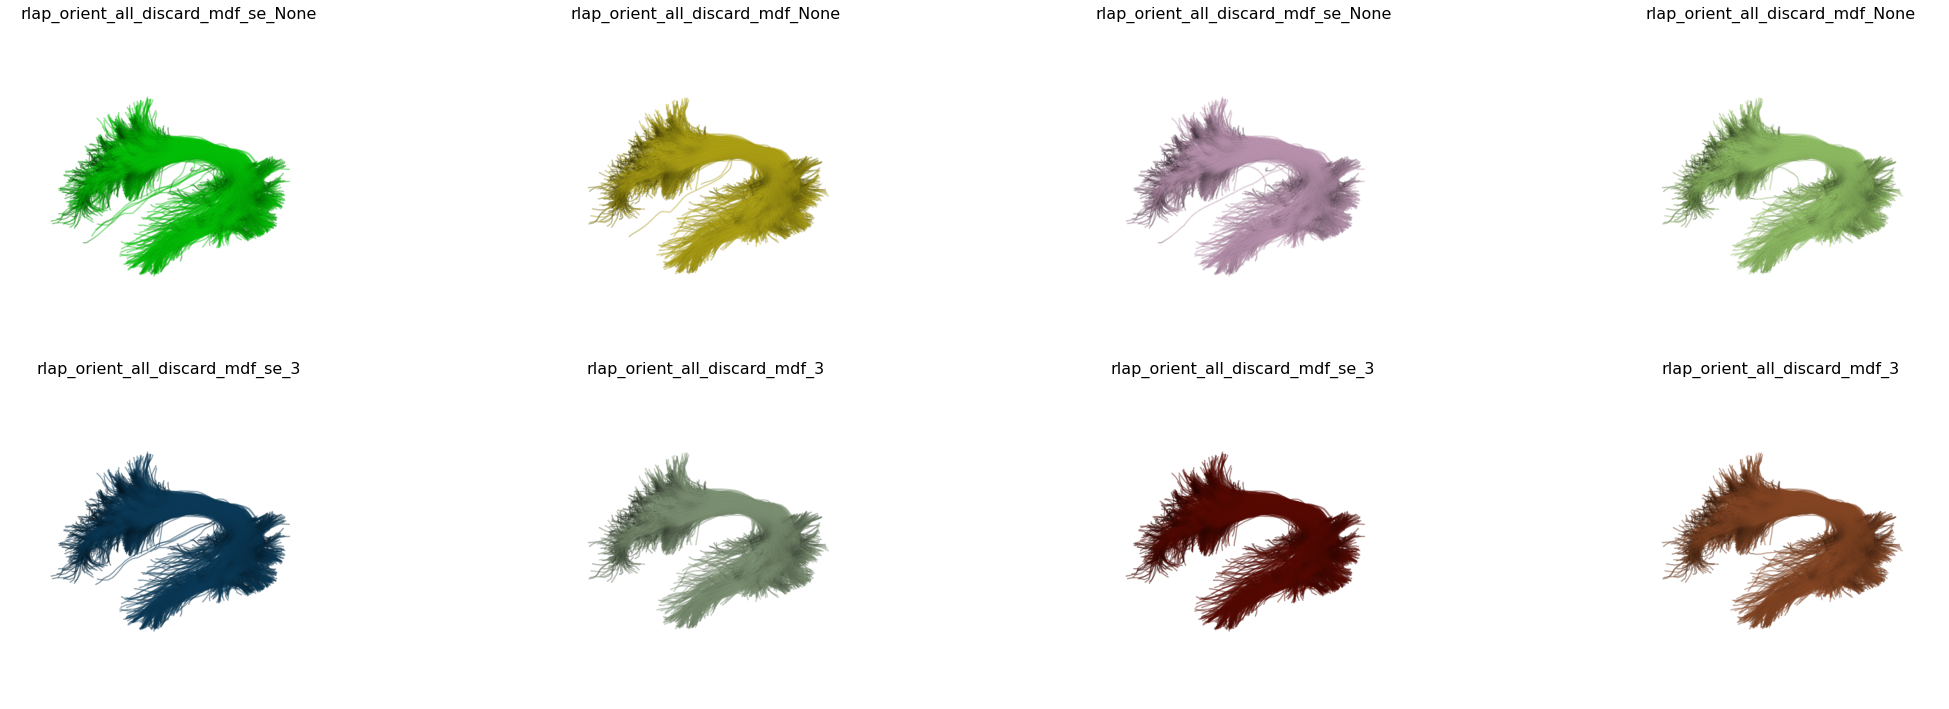

In [76]:
fig, axs = plt.subplots(2,4,figsize=(30,10))
plt.tight_layout()
for i, ax in enumerate(axs.reshape(-1)): 
    show_bundles(ax, [bundles[i]],labels = labels[i])

Due to the random selection of streamlines, spurious streamlines are only generated for certain seeds. To have a broader picture it should be desirable to run it multiple times.